In [1]:
import glob
import nibabel as nib
from nibabel.orientations import axcodes2ornt, ornt_transform, apply_orientation, ornt2axcodes
import ipympl
import os
%matplotlib widget
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import cupy as cp
from lito_radiomics.lito_radiomics.lito_features import shape2D
from cupyx.scipy import ndimage
from sklearn.calibration import LabelEncoder
from radiomics import featureextractor
import math
import SimpleITK as sitk
from skimage.measure import EllipseModel, find_contours
from skimage.draw import ellipse
from scipy import spatial
import datatable as dt
from PIL import Image
import scipy
import pickle

In [2]:
def compute_dice_ellipse(a, b, eigen_vect, mask_slice):
    
    angle1 = np.arctan(eigen_vect[1][1]/eigen_vect[1][0])
    angle2 = np.arctan(eigen_vect[1][1]/eigen_vect[1][0]) + np.deg2rad(90)

    center = ndimage.center_of_mass(cp.asarray(sitk.GetArrayFromImage(mask_slice)))
    xy1 = EllipseModel().predict_xy(np.linspace(0, 2 * np.pi, 25), params=(center[1].item(), center[0].item(), a, b, angle1))
    xy2 = EllipseModel().predict_xy(np.linspace(0, 2 * np.pi, 25), params=(center[1].item(), center[0].item(), a, b, angle2))
    ell1 = ellipse(center[1].item(), center[0].item(), a, b, rotation=angle1)
    ell2 = ellipse(center[1].item(), center[0].item(), a, b, rotation=angle2)

    contours = find_contours(sitk.GetArrayFromImage(mask_slice), 0.5)
    contours = [np.flip(contours[k]) for k in range(len(contours))]

    ellipse_estimation = EllipseModel()
    if ellipse_estimation.estimate(xy1):
        residuals1 = np.mean(np.concatenate([ellipse_estimation.residuals(contours[k]) for k in range(len(contours))]))
        
    if ellipse_estimation.estimate(xy2):
        residuals2 = np.mean(np.concatenate([ellipse_estimation.residuals(contours[k]) for k in range(len(contours))]))
        
    shape_slice = sitk.GetArrayFromImage(mask_slice).shape
    mask_ellipse1 = np.zeros(shape_slice)
    mask_ellipse1[[i for (i, j) in zip(ell1[::-1][0], ell1[::-1][1]) if (i<shape_slice[0] and j<shape_slice[1])], [j for (i, j) in zip(ell1[::-1][0], ell1[::-1][1]) if (i<shape_slice[0] and j<shape_slice[1])]] = 1

    mask_ellipse2 = np.zeros(shape_slice)
    mask_ellipse2[[i for (i, j) in zip(ell2[::-1][0], ell2[::-1][1]) if (i<shape_slice[0] and j<shape_slice[1])], [j for (i, j) in zip(ell2[::-1][0], ell2[::-1][1]) if (i<shape_slice[0] and j<shape_slice[1])]] = 1

    dice1=1-spatial.distance.dice(sitk.GetArrayFromImage(mask_slice).ravel(), mask_ellipse1.ravel())
    dice2=1-spatial.distance.dice(sitk.GetArrayFromImage(mask_slice).ravel(), mask_ellipse2.ravel())

    if dice1 >= dice2:
        return residuals1, dice1, xy1, mask_ellipse1, center
    else:
        return residuals2, dice2, xy2, mask_ellipse2, center

In [3]:
def check_orientation(ct_image, ct_arr):
    """
    Check the NIfTI orientation, and flip to  'LPS' if needed.
    :param ct_image: NIfTI file
    :param ct_arr: array file
    :return: array after flipping
    """

    original_ornt = nib.orientations.io_orientation(ct_image.affine)
    axcodes = ornt2axcodes(original_ornt)
    print(axcodes)
    # if axcodes == "('R', 'A', 'I')":
    rai_ornt = axcodes2ornt(('L', 'P', 'S'))
    transform = ornt_transform(original_ornt, rai_ornt)
    ct_arr = np.rot90(apply_orientation(ct_arr, transform), axes=(0,2), k=1)
    # else:
    #     print('here')
    #     rai_ornt = axcodes2ornt(('R', 'A', 'I'))
    #     transform = ornt_transform(original_ornt, rai_ornt)
    #     ct_arr = np.rot90(apply_orientation(ct_arr, transform), axes=(0,2), k=1)
    return ct_arr

In [4]:
def display_MIP(a_im, a_ma):
    mip_ax=  np.max(np.array(a_im), axis=0)
    mip_cor= np.max(np.array(a_im), axis=1)
    mip_sag= np.max(np.array(a_im), axis=2)

    mip_ax_mask=  np.max(np.array(a_ma), axis=0)
    mip_cor_mask= np.max(np.array(a_ma), axis=1)
    mip_sag_mask= np.max(np.array(a_ma), axis=2)

    plt.close('all')


    _, axs = plt.subplots(1, 3, figsize=(10, 8))
    for img, ma, ax in zip([mip_ax, mip_sag, mip_cor], [mip_ax_mask, mip_sag_mask, mip_cor_mask], axs):
        ax.imshow(img, cmap='grey', vmin=np.min(np.array(a_im)), vmax=np.max(np.array(a_im)))
        ax.imshow(ma, alpha=0.25*(ma>0))
    plt.show()

In [5]:
def remove_out_of_box_mask(mask, box):
    _, y, z = np.where(~box.mask)
    y_min = y.min()
    y_max = y.max()
    z_min = z.min()
    z_max = z.max()
    
    y_min_iso = int(y_max - (y_max-y_min)/2 - 25)
    y_max_iso = int(y_max - (y_max-y_min)/2 + 25)
    z_min_iso = int(z_max - (z_max-z_min)/2 - 25)
    z_max_iso = int(z_max - (z_max-z_min)/2 + 25)


    mask[:, :y_min_iso, :] = mask[:, y_max_iso+1:, :] = mask[:, :, :z_min_iso] = mask[:, :, z_max_iso+1:] = 0
    
    return mask
    

In [6]:
def resegment_thresholding(image, mask, thresh=0.2):
    
    max = (image*mask).max()
    print(thresh*max)
    new_mask20= np.ma.masked_where((image*mask) > thresh*max, mask)

    return new_mask20.mask.astype(float)

In [7]:
def standardize_roi(image, mask, desired_area):

    # Calculate the current area of the ROI
    current_area = cp.sum(mask)
    #print(current_area)
    # Calculate the scaling factor
    scale_factor = cp.sqrt(desired_area / current_area)
    #print(f'mask {str(mask.shape[0])} {str(mask.shape[1])} {str(scale_factor)}')
    
    return ndimage.zoom(cp.array(image), scale_factor), ndimage.zoom(cp.array(mask), scale_factor, order=0)


In [8]:
def _extracted_from_features_extraction2D_4(arg0, cut, data_spacing):
    result = sitk.GetImageFromArray(arg0[int(cut), :, :])
    result.SetSpacing(
        (
            float(data_spacing[0]),
            float(data_spacing[1]),
            float(data_spacing[2]),
        )
    )
    result = sitk.JoinSeries(result)

    return result

In [9]:
def ellipse_perimeter(a, b):
    """
    Compute the perimeter of an ellipse using Ramanujan's approximation formula.
    
    Parameters:
        a (float): Length of the semi-major axis.
        b (float): Length of the semi-minor axis.
    
    Returns:
        float: Perimeter of the ellipse.
    """
    h = ((a - b) / (a + b))**2
    perimeter = np.pi * (a + b) * (1 + (3 * h) / (10 + np.sqrt(4 - 3 * h)))
    return perimeter

In [10]:
def fill_holes(mask):
    filled_mask = scipy.ndimage.binary_fill_holes(mask[0, :, :]).astype(float)
    return filled_mask

In [11]:
def for_ellipse_creation(features_extractor, image, mask):
    results = features_extractor.execute(image, mask)
    features_lito = shape2D.LitoRadiomicsShape2D(image, mask)
    features_eigenvect = features_lito.getEigenVectorsFeatureValue()
    
    a = float(results['original_shape2D_MajorAxisLength'])/2  # Semi-major axis
    b = float(results['original_shape2D_MinorAxisLength'])/2  # Semi-minor axis
    perimeter = ellipse_perimeter(a, b)
    real_perimeter = float(results['original_shape2D_Perimeter'])
    ellipticity = perimeter/real_perimeter
    
    return results, features_eigenvect, a, b, ellipticity

In [12]:
# TODO Rename this here and in `features_extraction2D`
def _extracted_from_features_extraction2D_11():
    result = featureextractor.RadiomicsFeatureExtractor(force2D=True)
    result.disableAllFeatures()
    result.enableFeaturesByName(
        shape2D=[
            "PerimeterSurfaceRatio",
            "Sphericity",
            "MajorAxisLength",
            "MinorAxisLength",
            "Perimeter",
            "MeshSurface"
        ]
    )

    return result

In [13]:
def features_extraction2D(a_im, a_ma, cut, filled=True, for_display=True):

    data_spacing = [1,1,1]
    sitk_img = _extracted_from_features_extraction2D_4(a_im, cut, data_spacing)
    sitk_mask = _extracted_from_features_extraction2D_4(a_ma, cut, data_spacing)
    sitk_mask = sitk.Cast(sitk_mask, sitk.sitkInt32)

    if filled is True:
        sitk_mask = sitk.GetImageFromArray(fill_holes(sitk.GetArrayFromImage(sitk_mask)))
    resized_image, resized_mask = standardize_roi(sitk.GetArrayFromImage(sitk_img), sitk.GetArrayFromImage(sitk_mask), 1250)
    resized_image = sitk.GetImageFromArray(cp.asnumpy(resized_image))
    resized_mask = sitk.GetImageFromArray(cp.asnumpy(resized_mask))
    features_40_slice = _extracted_from_features_extraction2D_11()
    features_40_slice_resized = _extracted_from_features_extraction2D_11()
    try:
        image = sitk_img[:, :, 0] if filled is True else sitk_img
        resized_image = resized_image[:, :, 0] if filled is True else resized_image
        results, features_eigenvect, a, b, ellipticity = for_ellipse_creation(features_40_slice, image, sitk_mask)
        results_resized, features_eigenvect_resized, a_resized, b_resized, _ = for_ellipse_creation(features_40_slice_resized, resized_image, resized_mask)
    
        res, di, cont_ellipse, mask_ell, center = compute_dice_ellipse(a, b, features_eigenvect, sitk_mask)
        _, di_resized, _, _, _ = compute_dice_ellipse(a_resized, b_resized, features_eigenvect_resized, resized_mask)
        if for_display:
            return ellipticity, float(results['original_shape2D_PerimeterSurfaceRatio']), float(results['original_shape2D_Sphericity']), res, di, di_resized, cont_ellipse, mask_ell, center, float(results['original_shape2D_MeshSurface'])
        else:
            return ellipticity, float(results['original_shape2D_PerimeterSurfaceRatio']), float(results['original_shape2D_Sphericity']), res, di, di_resized, float(results['original_shape2D_MeshSurface'])
    except ValueError:
        if for_display:
            return None, None, None, None, None, None, None, None, None, None
        else:
            return None, None, None, None, None, None, None




In [14]:
def plot_slices(im, ma, bb, center_ells, slices_nbs, dices, ells):

    n = len(slices_nbs)
    n_columns = 8
    n_rows = n // n_columns

    if n % n_columns != 0:
        n_rows += 1
    plt.close('all')
    _, axs = plt.subplots(n_rows, n_columns, sharex=True, sharey=True, figsize=(20, 15))
    axs = axs.flatten()
    for i in range(n):
        inside_bb = bb[slices_nbs[i], :, :] * im[slices_nbs[i], :, :]
        to_display = np.ma.masked_equal(inside_bb, 0)

        y, z = np.where(~to_display.mask)
        y_min = y.min()
        y_max = y.max()
        z_min = z.min()
        z_max = z.max() 

        y_min_iso = int(y_max - (y_max-y_min)/2 - 25)
        y_max_iso = int(y_max - (y_max-y_min)/2 + 25)
        z_min_iso = int(z_max - (z_max-z_min)/2 - 25)
        z_max_iso = int(z_max - (z_max-z_min)/2 + 25)
        
        y_mask, x_mask = np.where(ma[slices_nbs[i], y_min_iso:y_max_iso+1, z_min_iso:z_max_iso+1]==1)
        x_min_mask = x_mask.min()
        x_max_mask = x_mask.max()
        y_min_mask = y_mask.min()
        y_max_mask = y_mask.max()
        
        vmin=np.min(im)
        vmax=np.max(im)
        #center_ma = [x_min_mask + (x_max_mask-x_min_mask)/2, y_min_mask + (y_max_mask-y_min_mask)/2]
        center = ndimage.center_of_mass(cp.asarray(ma[slices_nbs[i], y_min_iso:y_max_iso+1, z_min_iso:z_max_iso+1]))
        translated_ell = ells[i] - (np.array([center_ells[i][1].item(), center_ells[i][0].item()]) - np.array([center[1].item(), center[0].item()]))
        
        axs[i].imshow(im[slices_nbs[i], y_min_iso:y_max_iso+1, z_min_iso:z_max_iso+1], interpolation='none', cmap='grey', vmin=vmin, vmax=vmax)
        axs[i].imshow(ma[slices_nbs[i],y_min_iso:y_max_iso+1, z_min_iso:z_max_iso+1], alpha=0.25*(ma[slices_nbs[i],y_min_iso:y_max_iso+1, z_min_iso:z_max_iso+1]>0))
        axs[i].plot(translated_ell[:, 0], translated_ell[:, 1])
        axs[i].scatter(center[1].get(), center[0].get())
        #axs[i].scatter(center_ma[0], center_ma[1])
        axs[i].title.set_text(f'{str(dices[i])[:5]}')

    for ax in axs:
        if not bool(ax.get_images()):
            ax.remove()
    
    _.tight_layout()
    plt.show()

In [15]:
def rescale_to_255(array, min_val, max_val):
    """
    Rescale the values of a 2D NumPy array to the range [0, 255].
    
    Parameters:
        array (numpy.ndarray): Input 2D array.
        
    Returns:
        numpy.ndarray: Rescaled array with values in the range [0, 255].
    """

    # Ensure the array is not constant to avoid division by zero
    if min_val != max_val:
        scaled_array = 255 * (array - min_val) / (max_val - min_val)
    else:
        scaled_array = array

    return scaled_array.astype(np.uint8)

In [16]:
def save_slices_as_images(im, ma, bb, slice, dice, case, j, min_val, max_val):

    inside_bb = bb[slice, :, :] * im[slice, :, :]
    to_display = np.ma.masked_equal(inside_bb, 0)

    y, z = np.where(~to_display.mask)
    y_min = y.min()
    y_max = y.max()
    z_min = z.min()
    z_max = z.max() 

    y_min_iso = int(y_max - (y_max-y_min)/2 - 25)
    y_max_iso = int(y_max - (y_max-y_min)/2 + 25)
    z_min_iso = int(z_max - (z_max-z_min)/2 - 25)
    z_max_iso = int(z_max - (z_max-z_min)/2 + 25)
    im_to_save = Image.fromarray(rescale_to_255(im[slice, y_min_iso:y_max_iso+1, z_min_iso:z_max_iso+1], min_val, max_val))
    im_to_save = im_to_save.convert("L")
    
    with open(f'/mnt/data/psteinmetz/neotex/data_CNN/images_15062024/evaluation_IRM_villes/Arrays/{case}_{str(j)}_im.npy', 'wb') as f:
        np.save(f, im[slice, y_min_iso:y_max_iso+1, z_min_iso:z_max_iso+1])
    with open(f'/mnt/data/psteinmetz/neotex/data_CNN/images_15062024/evaluation_IRM_villes/Arrays/{case}_{str(j)}_ma.npy', 'wb') as f:
        np.save(f, ma[slice, y_min_iso:y_max_iso+1, z_min_iso:z_max_iso+1])

    if dice > 0.9:
        print('Round !')
        im_to_save.save(
            f"/mnt/data/psteinmetz/neotex/data_CNN/images_15062024/evaluation_IRM_villes/Round/{case}_{str(j)}"
            + ".png"
        )
    elif 0.8 < dice <=0.9:
        print('Ambiguous !')
        im_to_save.save(
            f"/mnt/data/psteinmetz/neotex/data_CNN/images_15062024/evaluation_IRM_villes/Ambiguous/{case}_{str(j)}"
            + ".png"
        )
    else:
        print('Irregular !')
        im_to_save.save(
            f"/mnt/data/psteinmetz/neotex/data_CNN/images_15062024/evaluation_IRM_villes/Irregular/{case}_{str(j)}"
            + ".png"
        )


In [17]:
path_data = glob.glob("/mnt/data/psteinmetz/neotex/to_process/*")
all_slices = {}
with cp.cuda.Device(1):
    for data in path_data:
        print(data)
        if '152' in data:
            image_path_sub = glob.glob(
                f'{data}/RawVolume/dyn1_resampled_bspline_zscore_without_tumor.nii.gz'
            )
            mask_path = glob.glob(f'{data}/RoiVolume/New_dyn1_C1_volume_resampled_NN.nii.gz')
            bb_path = glob.glob(f'{data}/RoiVolume/New_bb_dyn1_resampled.nii.gz')
        else:
            image_path_sub = glob.glob(
                f'{data}/RawVolume/substracted_resampled_bspline_zscore_without_tumor.nii.gz'
            )
            mask_path = glob.glob(f'{data}/RoiVolume/New_C1_volume_resampled_NN.nii.gz')
            bb_path = glob.glob(f'{data}/RoiVolume/New_bb_resampled_NN.nii.gz')
        if image_path_sub == []:
            print('problem image')
            pass
        elif mask_path == [] or bb_path == []:
            print('problem mask')
            pass
        else:
            image_sub = nib.load(image_path_sub[0])
            mask_bb = nib.load(bb_path[0])
            mask = nib.load(mask_path[0])
            
            image_sub = check_orientation(image_sub, np.array(image_sub.dataobj))
            mask_bb = check_orientation(mask_bb, np.array(mask_bb.dataobj))
            mask = check_orientation(mask, np.array(mask.dataobj))
            
            mask[mask >= 0.9] = 1
            mask[mask < 0.9] = 0
            mask_bb[mask_bb >= 0.9] = 1
            mask_bb[mask_bb < 0.9] = 0
            
            mask = remove_out_of_box_mask(mask, np.ma.masked_equal(mask_bb, 0))
            if '108' in data:
                mask = resegment_thresholding(image_sub, mask, thresh=0.4)
            elif '149' in data:
                mask = resegment_thresholding(image_sub, mask, thresh=0.05)
            elif '155' in data:
                mask = resegment_thresholding(image_sub, mask, thresh=0.05)
            elif '109' in data:
                mask = resegment_thresholding(image_sub, mask, thresh=0.3)
            else:
                mask = resegment_thresholding(image_sub, mask, thresh=0.1)
            image_sub = cp.float32(image_sub)
            mask = cp.float32(mask)
            mask_bb = cp.float32(mask_bb)
            
            #display_MIP(image_sub, mask_bb, mask)
            
            biggest_cut = np.max([np.count_nonzero(mask[k, :, :]) for k in range(mask.shape[0])])
            min_mask = np.argwhere(mask==1)[:, 0].min()
            max_mask = np.argwhere(mask==1)[:, 0].max()
            slices_nb = []
            dices = []
            ellipses = []
            centers = []
            

            list_slices = [features_extraction2D(image_sub, mask, k, for_display=False) for k in range(min_mask, max_mask+1) if np.count_nonzero(mask[k, :, :]) > 0.05*biggest_cut and features_extraction2D(image_sub, mask, k) is not None]
                    
            all_slices[data.split('//')[-1]] = pd.DataFrame(
                        list_slices,
                        columns=[
                            'ellipticity',
                            'original_shape2D_PerimeterSurfaceRatio',
                            'original_shape2D_Sphericity',
                            'Residuals',
                            'Dice',
                            'Dice_resized',
                            'original_shape2D_MeshSurface'
                        ],
                    )
                
                        
            with open('/mnt/data/psteinmetz/neotex/CSV/slices_villes_thresholded10_filled_resized.pickle', 'wb') as handle:
                pickle.dump(all_slices, handle, protocol=pickle.HIGHEST_PROTOCOL)

/mnt/data/psteinmetz/neotex/to_process/136
('R', 'A', 'I')
('R', 'A', 'I')
('R', 'A', 'I')
0.5707705249864853


KeyboardInterrupt: 

In [ ]:
path_data = glob.glob("/mnt/data/psteinmetz/neotex/to_process/*")
with cp.cuda.Device(1):
    for data in path_data:
        print(data)
        if '152' in data:
            image_path_sub = glob.glob(
                f'{data}/RawVolume/dyn1_resampled_bspline_zscore_without_tumor.nii.gz'
            )
            mask_path = glob.glob(f'{data}/RoiVolume/New_dyn1_C1_volume_resampled_NN.nii.gz')
            bb_path = glob.glob(f'{data}/RoiVolume/New_bb_dyn1_resampled.nii.gz')
        else:
            image_path_sub = glob.glob(
                f'{data}/RawVolume/substracted_resampled_bspline_zscore_without_tumor.nii.gz'
            )
            mask_path = glob.glob(f'{data}/RoiVolume/New_C1_volume_resampled_NN.nii.gz')
            bb_path = glob.glob(f'{data}/RoiVolume/New_bb_resampled_NN.nii.gz')
            
        if image_path_sub == []:
            print('problem image')
            pass
        elif mask_path == [] or bb_path == []:
            print('problem mask')
            pass
        else:
            if '155' in data:
                image_sub = nib.load(image_path_sub[0])
                mask_bb = nib.load(bb_path[0])
                mask = nib.load(mask_path[0])
                
                image_sub = check_orientation(image_sub, np.array(image_sub.dataobj))
                mask_bb = check_orientation(mask_bb, np.array(mask_bb.dataobj))
                mask = check_orientation(mask, np.array(mask.dataobj))
                
                mask[mask >= 0.9] = 1
                mask[mask < 0.9] = 0
                mask_bb[mask_bb >= 0.9] = 1
                mask_bb[mask_bb < 0.9] = 0
                
                mask = remove_out_of_box_mask(mask, np.ma.masked_equal(mask_bb, 0))
                if '108' in data:
                    mask = resegment_thresholding(image_sub, mask, thresh=0.4)
                elif '149' in data:
                    mask = resegment_thresholding(image_sub, mask, thresh=0.05)
                elif '155' in data:
                    mask = resegment_thresholding(image_sub, mask, thresh=0.05)
                elif '109' in data:
                    mask = resegment_thresholding(image_sub, mask, thresh=0.3)
                else:
                    mask = resegment_thresholding(image_sub, mask, thresh=0.1)
                image_sub = cp.float32(image_sub)
                mask = cp.float32(mask)
                mask_bb = cp.float32(mask_bb)
                
                #display_MIP(image_sub, mask_bb, mask)
                
                biggest_cut = np.max([np.count_nonzero(mask[k, :, :]) for k in range(mask.shape[0])])
                min_mask = np.argwhere(mask==1)[:, 0].min()
                max_mask = np.argwhere(mask==1)[:, 0].max()
                slices_nb = []
                dices = []
                dices_resized = []
                ellipses = []
                centers = []
                for x in range(min_mask, max_mask+1):
                    slice_ma_for_db = mask[x, :, :]

                    if np.count_nonzero(slice_ma_for_db) > 0.05*biggest_cut:
                        ellipticity, peri_surf_ratio, sphericity, residuals, dice, dice_resized, cont_ellipse, mask_ell, center, mesh_surface = features_extraction2D(image_sub, mask, x)
                        slices_nb.append(x)
                        dices.append(dice)
                        dices_resized.append(dice_resized)
                        ellipses.append(cont_ellipse)
                        centers.append(center)
                plt.close('all')
                plot_slices(image_sub, mask, mask_bb, centers, slices_nb, dices, ellipses)
        
        

In [ ]:
path_data = glob.glob("/mnt/data/psteinmetz/neotex/to_process/*")
log = {}
with cp.cuda.Device(1):
    for data in path_data:
        print(data)
        if '152' in data:
            image_path_sub = glob.glob(
                f'{data}/RawVolume/dyn1_resampled_bspline_zscore_without_tumor.nii.gz'
            )
            mask_path = glob.glob(f'{data}/RoiVolume/New_dyn1_C1_volume_resampled_NN.nii.gz')
            bb_path = glob.glob(f'{data}/RoiVolume/New_bb_dyn1_resampled.nii.gz')
        else:
            image_path_sub = glob.glob(
                f'{data}/RawVolume/substracted_resampled_bspline_zscore_without_tumor.nii.gz'
            )
            mask_path = glob.glob(f'{data}/RoiVolume/New_C1_volume_resampled_NN.nii.gz')
            bb_path = glob.glob(f'{data}/RoiVolume/New_bb_resampled_NN.nii.gz')
            
        if image_path_sub == []:
            print('problem image')
            pass
        elif mask_path == [] or bb_path == []:
            print('problem mask')
            pass
        else:    
            image_sub = nib.load(image_path_sub[0])
            mask_bb = nib.load(bb_path[0])
            mask = nib.load(mask_path[0])
            
            image_sub = check_orientation(image_sub, np.array(image_sub.dataobj))
            mask_bb = check_orientation(mask_bb, np.array(mask_bb.dataobj))
            mask = check_orientation(mask, np.array(mask.dataobj))
            
            mask[mask >= 0.9] = 1
            mask[mask < 0.9] = 0
            mask_bb[mask_bb >= 0.9] = 1
            mask_bb[mask_bb < 0.9] = 0
            
            mask = remove_out_of_box_mask(mask, np.ma.masked_equal(mask_bb, 0))
            if '108' in data:
                mask = resegment_thresholding(image_sub, mask, thresh=0.4)
            elif '149' in data:
                mask = resegment_thresholding(image_sub, mask, thresh=0.05)
            elif '155' in data:
                mask = resegment_thresholding(image_sub, mask, thresh=0.05)
            elif '109' in data:
                mask = resegment_thresholding(image_sub, mask, thresh=0.3)
            else:
                mask = resegment_thresholding(image_sub, mask, thresh=0.1)
            image_sub = cp.float32(image_sub)
            mask = cp.float32(mask)
            mask_bb = cp.float32(mask_bb)
            
            #display_MIP(image_sub, mask_bb, mask)
            
            biggest_cut = np.max([np.count_nonzero(mask[k, :, :]) for k in range(mask.shape[0])])
            min_mask = np.argwhere(mask==1)[:, 0].min()
            max_mask = np.argwhere(mask==1)[:, 0].max()
            i = 0
            case = data.split('/')[-1]
            for x in range(min_mask, max_mask+1):
                slice_ma_for_db = mask[x, :, :]

                if np.count_nonzero(slice_ma_for_db) > 0.05*biggest_cut:
                    ellipticity, peri_surf_ratio, sphericity, residuals, dice, dice_resized, cont_ellipse, mask_ell, center, mesh_surface = features_extraction2D(image_sub, mask, x)
                    log[f"{case}_{str(i)}"] = (dice)
                    min_val = image_sub.min().item()
                    max_val = image_sub.max().item()
                    save_slices_as_images(image_sub, mask, mask_bb, x, dice, case, i, min_val, max_val)
                    i=i+1
        with open('/mnt/data/psteinmetz/neotex/data_CNN/images_15062024/evaluation_IRM_villes/log.pickle', 'wb') as handle:
            pickle.dump(log, handle, protocol=pickle.HIGHEST_PROTOCOL)
                
        
        

In [17]:
def check_orientation_tr(ct_image, ct_arr):
    """
    Check the NIfTI orientation, and flip to  'RPS' if needed.
    :param ct_image: NIfTI file
    :param ct_arr: array file
    :return: array after flipping
    """
    x, y, z = nib.aff2axcodes(ct_image.affine)
    
    if x != 'R':
        ct_arr = np.rot90(ct_arr, axes=(0,2), k=1)
    if y != 'P':
        ct_arr = np.flip(ct_arr, axis=1)
    if z != 'S':
        ct_arr = np.flip(ct_arr, axis=2)
    
    return ct_arr

In [18]:
def check_registration_tr(im1, im2):
    ax, az=im1.header['qoffset_x'], im1.header['qoffset_z']
    bx, bz=im2.header['qoffset_x'], im2.header['qoffset_z']

    return bool(
        math.isclose(az, bz, rel_tol=0.05)
        and math.isclose(ax, bx, rel_tol=0.05)
    )

In [19]:
def save_slices_as_images_tr(im, bb, slice, case, j, min_val, max_val):

    inside_bb = bb[slice, :, :] * im[slice, :, :]
    to_display = np.ma.masked_equal(inside_bb, 0)

    y, z = np.where(~to_display.mask)
    y_min = y.min()
    y_max = y.max()
    z_min = z.min()
    z_max = z.max() 

    y_min_iso = int(y_max - (y_max-y_min)/2 - 25)
    y_max_iso = int(y_max - (y_max-y_min)/2 + 25)
    z_min_iso = int(z_max - (z_max-z_min)/2 - 25)
    z_max_iso = int(z_max - (z_max-z_min)/2 + 25)
    im_to_save = Image.fromarray(rescale_to_255(im[slice, y_min_iso:y_max_iso+1, z_min_iso:z_max_iso+1], min_val, max_val))
    im_to_save = im_to_save.convert("L")
    im_to_save.save(f"/mnt/data/psteinmetz/neotex/data_CNN/model_evaluation/evaluation_Ozgun/{case}_{str(j)}" + ".png")

In [37]:
path_data = "/mnt/data/ffrouin/NEOTEX/DATA_NIFTI/DataMerged/"
list_cases = os.listdir(path_data)
log = {}
count = 1
for case in list_cases:
    if '.' not in case:
        print(case)
        path_data = f"/mnt/data/ffrouin/NEOTEX/DATA_NIFTI/DataMerged/{str(case)}"
        if case!='39':
            image_path_sub = glob.glob(
                f'{path_data}/RawVolume/*substracted*_Bspline_zscore_without_tumour.nii.gz'
            )
            image_path_dyn = glob.glob(
                f'{path_data}/RawVolume/*dyn1*_Bspline_zscore_without_tumour.nii.gz'
            )
        else:
            image_path_sub = glob.glob(
                f'{path_data}/RawVolume/*dyn1*_Bspline_zscore_without_tumour.nii.gz'
            )
        mask_bb_path = glob.glob(f'{path_data}/RoiVolume/Bounding_box.nii.gz')
        if case == '72':
            mask_path = glob.glob('/mnt/data/psteinmetz/C1_volume_resampled_NN.uint16.nii.gz')
        else:
            mask_path = glob.glob(f'{path_data}/RoiVolume/C1_volume_resampled_NN.nii.gz')

        mask_bb = nib.load(mask_bb_path[0])
        mask = nib.load(mask_path[0])
        if case!='39':
            image_sub = nib.load(image_path_sub[0])
            image_dyn = nib.load(image_path_dyn[0])
            x = check_registration_tr(image_sub, image_dyn)
            image = image_sub if x is True else image_dyn
        else:
            image = nib.load(image_path_sub[0])

        a_im = nib.Nifti1Image(check_orientation_tr(image, np.array(image.dataobj)), affine=image.affine)
        a_ma = check_orientation_tr(mask, np.array(mask.dataobj))
        a_ma[a_ma > 0.1] = 1
        a_ma[a_ma <=0.1] = 0
        a_ma = nib.Nifti1Image(a_ma, affine=mask.affine)
        a_ma_bb = check_orientation_tr(mask_bb, np.array(mask_bb.dataobj))
        a_ma_bb = nib.Nifti1Image(np.ma.masked_where(a_ma_bb>0.1, a_ma_bb), affine=mask_bb.affine)
        image_sub = cp.float32(np.array(a_im.dataobj))
        mask = cp.float32(np.array(a_ma.dataobj))
        mask_bb = cp.float32(np.array(a_ma_bb.dataobj))
        biggest_cut = np.max([np.count_nonzero(mask[k, :, :]) for k in range(mask.shape[0])])
        min_mask = np.argwhere(mask==1)[:, 0].min()
        max_mask = np.argwhere(mask==1)[:, 0].max()
        i = 0
        
        for x in range(min_mask, max_mask+1):
            slice_ma_for_db = mask[x, :, :]

            if np.count_nonzero(slice_ma_for_db) > 0.05*biggest_cut:
                min_val = image_sub.min().item()
                max_val = image_sub.max().item()
                save_slices_as_images_tr(image_sub, mask_bb, x, case, i, min_val, max_val)
                i=i+1

7
6
82
105
22
90
38
45
51
74
32
102
67
18
96
68
2
48
26
95
88
65
101
78
1
58
79
4
91
63
54
52
62
44
50
86
92
29
33
61
46
34
24
19
85
36
89
23
10
42
28
5
30
14
98
73
97
59
27
21
64
9
75
56
20
69
8
93
104
81
77
25
15
43
55
71
60
49
41
72
84
37
31
12
40
83
76
70
66
16
57
17
80
103
35
13
47
94
99
87
100
53
39


In [32]:
path_data + case

'/mnt/data/psteinmetz/neotex/to_process/Ozgun/221'

In [20]:
path_data = "/mnt/data/psteinmetz/neotex/to_process/Ozgun/"
list_cases = os.listdir(path_data)
log = {}
for case in list_cases:
    if '.' not in case:
        print(case)
        
        image_path_sub = glob.glob(
            f'{path_data + case}/RawVolume/*subtracted*.nii.gz'
        )
        mask_bb_path = glob.glob(f'{path_data + case}/RoiVolume/VOI_bb.nii.gz')
        mask_path = glob.glob(f'{path_data + case}/RoiVolume/VOI.nii.gz')

        mask_bb = nib.load(mask_bb_path[0])
        mask = nib.load(mask_path[0])
        
        image = nib.load(image_path_sub[0])

        a_im = nib.Nifti1Image(check_orientation_tr(image, np.array(image.dataobj)), affine=image.affine)
        a_ma = check_orientation_tr(mask, np.array(mask.dataobj))
        a_ma[a_ma > 0.1] = 1
        a_ma[a_ma <=0.1] = 0
        a_ma = nib.Nifti1Image(a_ma, affine=mask.affine)
        a_ma_bb = check_orientation_tr(mask_bb, np.array(mask_bb.dataobj))
        a_ma_bb = nib.Nifti1Image(np.ma.masked_where(a_ma_bb>0.1, a_ma_bb), affine=mask_bb.affine)
        image_sub = cp.float32(np.array(a_im.dataobj))
        mask = cp.float32(np.array(a_ma.dataobj))
        mask_bb = cp.float32(np.array(a_ma_bb.dataobj))
        biggest_cut = np.max([np.count_nonzero(mask[k, :, :]) for k in range(mask.shape[0])])
        
        min_mask = np.argwhere(mask==1)[:, 0].min()
        max_mask = np.argwhere(mask==1)[:, 0].max()
        i = 0
        
        for x in range(min_mask, max_mask+1):
            slice_ma_for_db = mask[x, :, :]

            if np.count_nonzero(slice_ma_for_db) > 0.1*biggest_cut:
                min_val = image_sub.min().item()
                max_val = image_sub.max().item()
                save_slices_as_images_tr(image_sub, mask_bb, x, case, i, min_val, max_val)
                i=i+1

221
197
220
188
213
190
181
219
167
216
165
179
210
183
170
187
202
209
222
163
166
176
162
175
191
215
214
192
193
184
205
185
161
182
168
173
223
174
204
160
178
208
217
180
195
189
177
194
200
201
159
171
203
164
207
172
198
206
196
186
212
218
199
211
169


In [34]:
with open('/mnt/data/psteinmetz/neotex/CSV/slices_villes_thresholded10_filled_resized.pickle', 'rb') as handle:
    axial_cuts_data = pickle.load(handle)

In [35]:
plt.close('all')
path_data = "/mnt/data/ffrouin/NEOTEX/DATA_NIFTI/DataMerged/"
path_to_csv = r'/mnt/data/psteinmetz/neotex/CSV/BOUNDING_BOX.csv'
path_to_csv_ville = r'/mnt/data/psteinmetz/neotex/CSV/Bounding_box_ville.csv'

data_train = pd.concat((dt.fread(path_to_csv).to_pandas(), dt.fread(path_to_csv_ville).to_pandas()), ignore_index=True).dropna(axis=1)
shape_target_train = pd.concat((data_train[['Record_ID']], data_train[['Shape.1']]), axis=1)

list_cases = os.listdir(path_data)

shape_modified = shape_target_train.replace('Oval', 'Round')
big_size_cuts = {k:v[v['original_shape2D_MeshSurface'] >= v['original_shape2D_MeshSurface'].quantile(0.25)] for (k,v) in axial_cuts_data.items()}


/tmp/ipykernel_2921679/1841347349.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data_train = pd.concat((dt.fread(path_to_csv).to_pandas(), dt.fread(path_to_csv_ville).to_pandas()), ignore_index=True).dropna(axis=1)


In [36]:
new_big_size_cuts = {k.split('/')[-1]:v.assign(Shape=shape_modified['Shape.1'][shape_modified['Record_ID'] == int(k.split('/')[-1])].iloc[0]) for (k,v) in big_size_cuts.items() if int(k.split('/')[-1]) in shape_modified[['Record_ID']].values}

In [37]:
del new_big_size_cuts['145']

In [40]:
shape_modified

,Record_ID,Shape.1
0,1,Irregular
1,2,Irregular
2,4,Irregular
3,5,Irregular
4,6,Round
...,...,...
131,152,Irregular
132,153,Irregular
133,154,Irregular
134,155,Round


array([<Axes: title={'center': 'Irregular'}, ylabel='Frequency'>,
       <Axes: title={'center': 'Round'}, ylabel='Frequency'>],
      dtype=object)

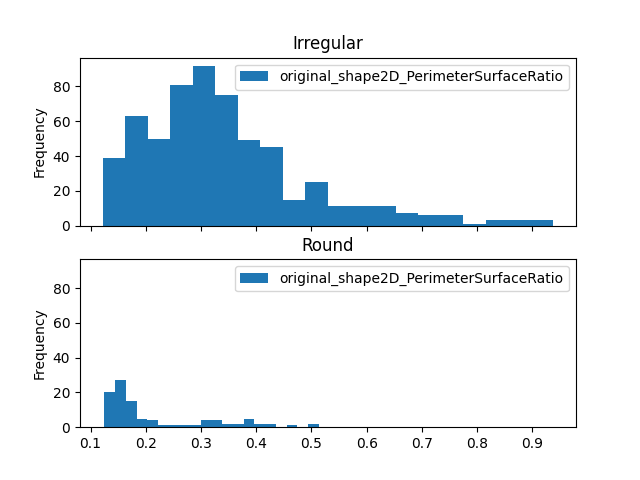

In [38]:
to_plot = pd.concat(new_big_size_cuts, axis=0)
to_plot['original_shape2D_PerimeterSurfaceRatio'] = to_plot['original_shape2D_PerimeterSurfaceRatio'].astype(float)

order_list_psratio = to_plot.groupby(level=0)['original_shape2D_PerimeterSurfaceRatio'].median().sort_values().index
order_list_sphericity = to_plot.groupby(level=0)['original_shape2D_Sphericity'].median().sort_values().index
order_list_ellipticity = to_plot.groupby(level=0)['ellipticity'].median().sort_values().index
order_list_dice = to_plot.groupby(level=0)['Dice'].median().sort_values().index
order_list_dice_resized = to_plot.groupby(level=0)['Dice_resized'].median().sort_values().index
order_list_residuals = to_plot.groupby(level=0)['Residuals'].median().sort_values().index
#order_list_haussdorff = to_plot.groupby(level=0)['Haussdorff'].median().sort_values().index

to_plot.plot.hist(column='original_shape2D_PerimeterSurfaceRatio', by="Shape", sharex=True, sharey=True, bins=20)

array([<Axes: title={'center': 'Irregular'}, ylabel='Frequency'>,
       <Axes: title={'center': 'Round'}, ylabel='Frequency'>],
      dtype=object)

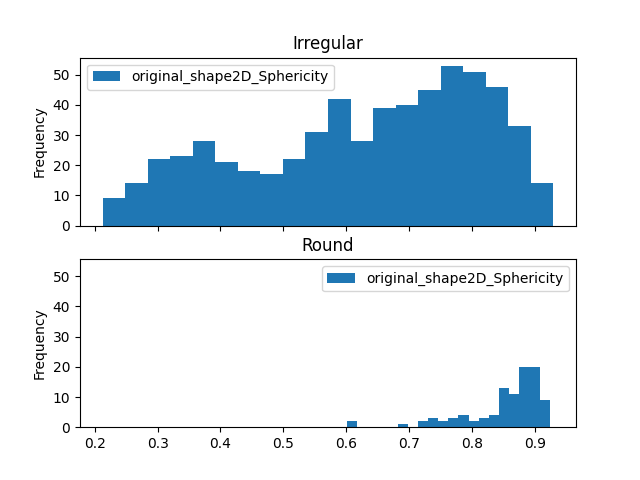

In [23]:
to_plot.plot.hist(column='original_shape2D_Sphericity', by="Shape", sharex=True, sharey=True, bins=20)

array([<Axes: title={'center': 'Irregular'}, ylabel='Frequency'>,
       <Axes: title={'center': 'Round'}, ylabel='Frequency'>],
      dtype=object)

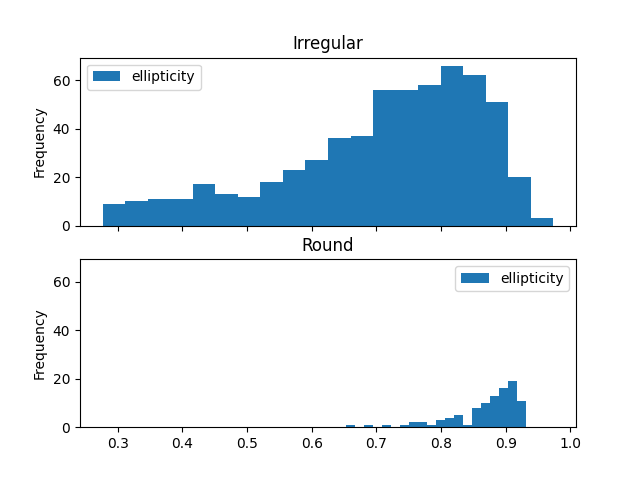

In [24]:
to_plot.plot.hist(column='ellipticity', by="Shape", sharex=True, sharey=True, bins=20)

array([<Axes: title={'center': 'Irregular'}, ylabel='Frequency'>,
       <Axes: title={'center': 'Round'}, ylabel='Frequency'>],
      dtype=object)

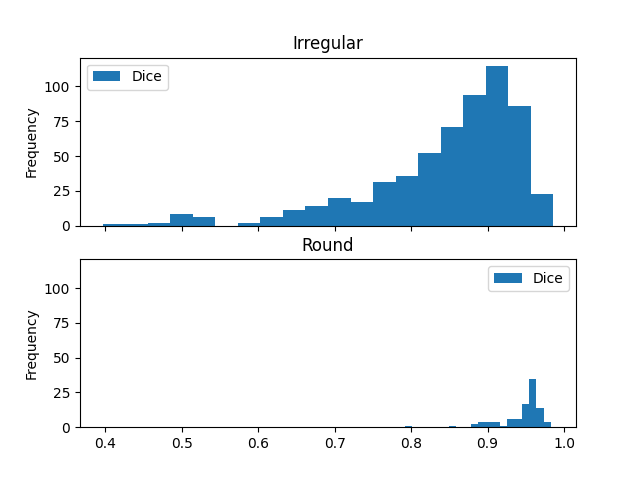

In [25]:
to_plot.plot.hist(column='Dice', by="Shape", sharex=True, sharey=True, bins=20)

array([<Axes: title={'center': 'Irregular'}, ylabel='Frequency'>,
       <Axes: title={'center': 'Round'}, ylabel='Frequency'>],
      dtype=object)

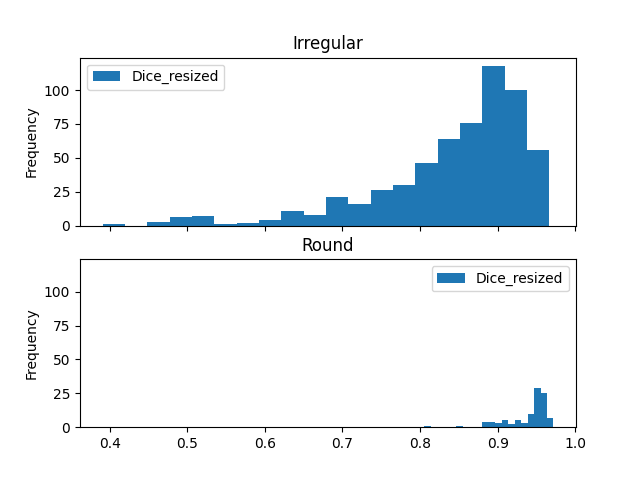

In [26]:
to_plot.plot.hist(column='Dice_resized', by="Shape", sharex=True, sharey=True, bins=20)

array([<Axes: title={'center': 'Irregular'}, ylabel='Frequency'>,
       <Axes: title={'center': 'Round'}, ylabel='Frequency'>],
      dtype=object)

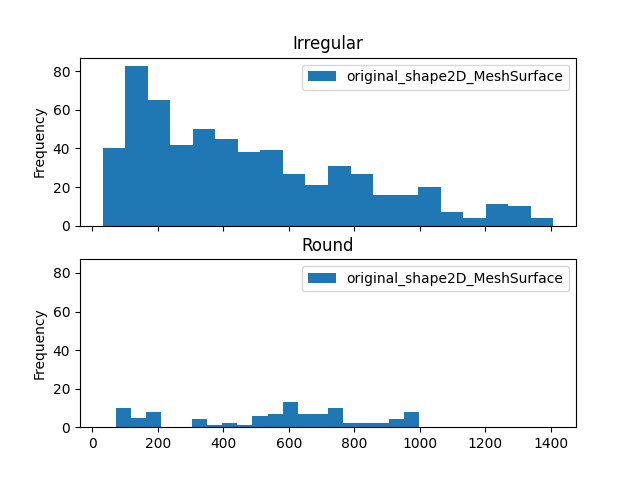

In [27]:
to_plot.plot.hist(column='original_shape2D_MeshSurface', by="Shape", sharex=True, sharey=True, bins=20)

array([<Axes: title={'center': 'Irregular'}, ylabel='Frequency'>,
       <Axes: title={'center': 'Round'}, ylabel='Frequency'>],
      dtype=object)

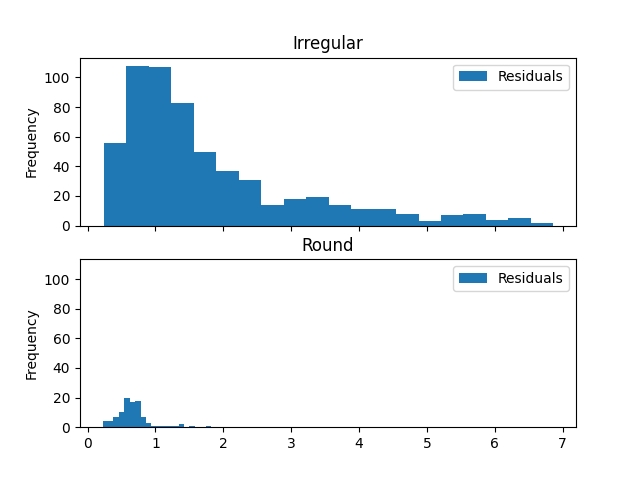

In [28]:
to_plot.plot.hist(column='Residuals', by="Shape", sharex=True, sharey=True, bins=20)

In [26]:
le = LabelEncoder()
le.fit_transform(to_plot['Shape'])

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

<Axes: xlabel='original_shape2D_Sphericity', ylabel='original_shape2D_PerimeterSurfaceRatio'>

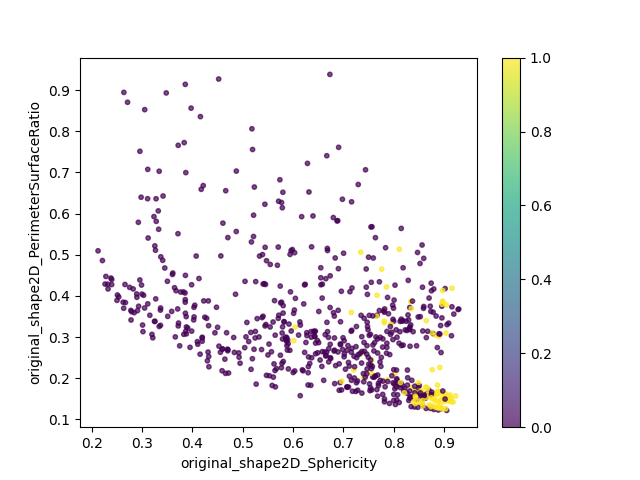

In [27]:
le = LabelEncoder()
le.fit(to_plot['Shape'])
to_plot.plot.scatter(x='original_shape2D_Sphericity', y='original_shape2D_PerimeterSurfaceRatio', c=le.fit_transform(to_plot['Shape']), colormap='viridis', alpha=0.7, s=10)

5560

<Axes: xlabel='ellipticity', ylabel='Dice'>

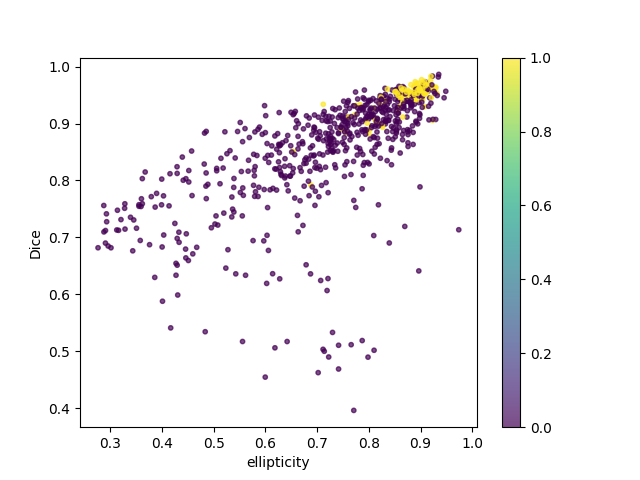

In [28]:
le = LabelEncoder()
le.fit(to_plot['Shape'])
to_plot.plot.scatter(x='ellipticity', y='Dice', c=le.fit_transform(to_plot['Shape']), colormap='viridis', alpha=0.7, s=10)

In [ ]:
to_plot.sort_values(by='Shape', inplace=True)
to_plot = to_plot.reindex(order_list_sphericity, level=0)
sns.catplot(data=to_plot, x='original_shape2D_Sphericity', y=to_plot.index.get_level_values(0), hue='Shape', kind='box', ci=None, palette=["C1", "C0"])

In [ ]:
to_plot = to_plot.reindex(order_list_ellipticity, level=0)
sns.catplot(data=to_plot, x='ellipticity', y=to_plot.index.get_level_values(0), hue='Shape', kind='box', ci=None, palette=["C1", "C0"])

In [33]:
to_plot.index.get_level_values(0).unique().size

31

/tmp/ipykernel_3052856/638674004.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.catplot(data=to_plot, x='original_shape2D_PerimeterSurfaceRatio', y=to_plot.index.get_level_values(0), hue='Shape', kind='box', ci=None, palette=["C0", "C1"])


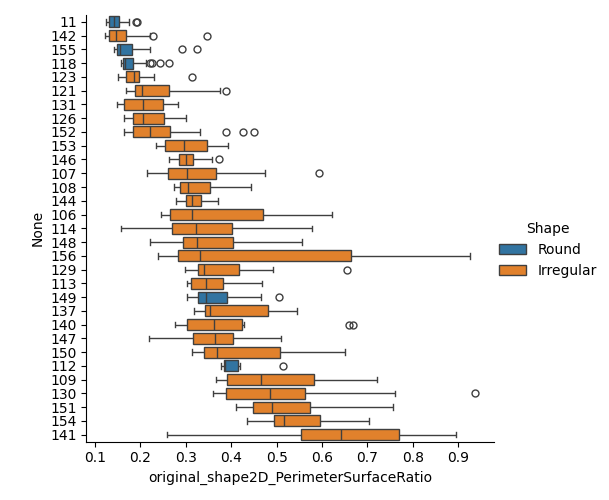

In [34]:
to_plot = to_plot.reindex(order_list_psratio, level=0)
sns.catplot(data=to_plot, x='original_shape2D_PerimeterSurfaceRatio', y=to_plot.index.get_level_values(0), hue='Shape', kind='box', ci=None, palette=["C0", "C1"])

/tmp/ipykernel_3052856/1876990881.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.catplot(data=to_plot, x='Dice', y=to_plot.index.get_level_values(0), hue='Shape', kind='box', ci=None, palette=["C0", "C1"])


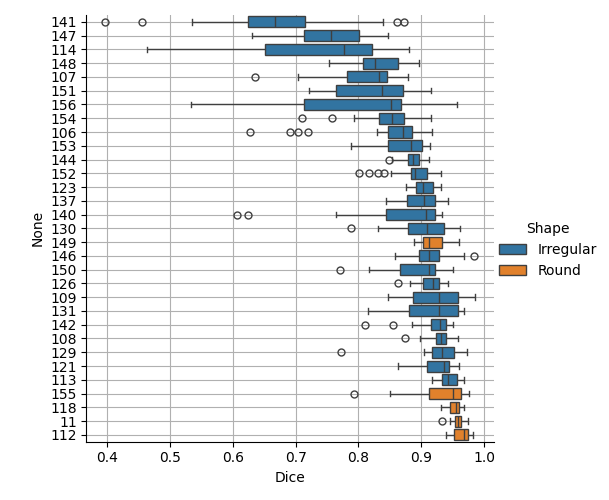

In [35]:
plt.close('all')
to_plot = to_plot.reindex(order_list_dice, level=0)
sns.catplot(data=to_plot, x='Dice', y=to_plot.index.get_level_values(0), hue='Shape', kind='box', ci=None, palette=["C0", "C1"])
plt.grid()
plt.show()

In [ ]:
plt.close('all')
to_plot = to_plot.reindex(order_list_dice_resized, level=0)
sns.catplot(data=to_plot, x='Dice_resized', y=to_plot.index.get_level_values(0), hue='Shape', kind='box', ci=None, palette=["C0", "C1"])
plt.grid()
plt.show()

In [ ]:
to_plot = to_plot.reindex(order_list_residuals, level=0)
sns.catplot(data=to_plot, x='Residuals', y=to_plot.index.get_level_values(0), hue='Shape', kind='box', ci=None, palette=["C1", "C0"])